# Imports & Parameters

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

START_DATE = "2018-01-01"
END_DATE = "2024-12-31"

INITIAL_CAPITAL = 100_000 #start with $100,000
DTE = 30 #choose 30 days till expiration
OTM_PCT = 0.08 #out of the money --> selling with a strike price 8% lower than current price
PROFIT_TARGET = 0.5 #when open market gain hits 50%, close the position and start a new one
RISK_FREE_RATE = 0.02 #the interest you would get by just leaving cash in a savings account

# Cash-Secured Put Backtest — AAPL

**Hypothesis:**  
Selling 30–45 DTE cash-secured puts on AAPL and closing at 50% max profit
outperforms buy-and-hold on a risk-adjusted basis.

## Strategy Definition
- Underlying: AAPL
- Strategy: Cash-Secured Puts
- Entry frequency: Every 30 trading days if no open position
- DTE: 30
- Strike selection: 8% out-of-the-money
- Premium model: Volatility-based approximation
- Exit rules:
  - At expiration OR
  - 50% of max profit (if modeled)
- Assignment handling: Assigned shares valued at expiration close

## Risk & Capital Rules
- Initial capital: $100,000
- Position sizing: 1 contract per trade
- No leverage
- No margin
- Transaction costs: $0 (initially)

## Assumptions & Limitations
- Uses realized volatility as IV proxy
- Assumes fills at theoretical price
- Ignores early assignment

# Price Data and Option Pricing

In [159]:
#price data
ticker = "AAPL"
df = yf.download(ticker, start = START_DATE, end = END_DATE)
df = df[["Close"]]
df["return"] = df["Close"].pct_change() #we use returns to predict realized volatility

# Flatten headers if they are MultiIndex
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

#volatility (vol)
df["vol"] = df["return"].rolling(30).std()*np.sqrt(252) #rolling is used for moving averages, volatility is defined by the standard deviation
df["vol"] = df["vol"].bfill()
df = df.dropna()

[*********************100%***********************]  1 of 1 completed


# Strategy Logic (core backtest loop)

In [160]:
trades = []
capital = INITIAL_CAPITAL
i = 0
while i < (len(df)-DTE):
    stop = "no"
    days_held = 0
    temp_entry_date = df.index[i]
    pnl = 0 
   
    expiration_price_at_term = df["Close"].iloc[i + DTE].item() #30 days from purchase price, expiration price of the stock
    vol = df["vol"].iloc[i].item()
    strike = df["Close"].iloc[i].item() * (1 - OTM_PCT)
    event = ""
    premium =  0.3 * strike * np.sqrt(DTE / 365) * vol #using the Brenner-Subrahmanyam approximation for premium prices 
    contract_cost = strike*100
    num_contracts = int(capital/contract_cost)
    if(num_contracts < 1):
        break
    for j in range(0, DTE +1): #End date is 32 days after
        #Option value calculation
        current_vol = df["vol"].iloc[i+j].item() 
        current_market_premium = 0.3 * strike * np.sqrt(DTE / 365) * current_vol
        current_price = df["Close"].iloc[j + i]        
        days_remaining = (DTE - j)
        time_value = 0.3 * strike * np.sqrt(days_remaining / 365) * current_vol
        intrinsic_value = max(0, strike - current_price)
        current_option_value = intrinsic_value + time_value #Extrinsic value is the time value

        #check 50%     
        current_profit_pct = (premium-current_option_value)/premium

        if (current_profit_pct >= .5):              
            pnl = (premium-current_option_value)*num_contracts*100           
            event = "rolled"
            expiration_date = df.index[i + j]
            days_held = j
            stop = "yes"
            break

    if(stop != "yes"):
        expiration_price_at_term = df["Close"].iloc[i + DTE]
        if (expiration_price_at_term > strike): #csp expires, nothing happens
            pnl = premium*100*num_contracts
            event = "expired_no_assignment" 
            expiration_date = df.index[i + DTE]             
            days_held = DTE
            i += days_held
            capital += pnl
            trades.append({
            "num_contracts":num_contracts,
            "entry_date": temp_entry_date,
            "expiration_date": expiration_date,
            "strike": strike,
            "premium": premium,
            "pnl": pnl,
            "capital": capital,
            "event": event,
            "days_held": days_held
            })  
        else:
            pnl = (premium - (strike - expiration_price_at_term))*100*num_contracts #when shares get assigned  
            event = "expired_assignment"
            days_held = DTE
            i += days_held
            expiration_date = df.index[i + DTE]
            capital += pnl
            trades.append({
            "num_contracts":num_contracts,
            "entry_date": temp_entry_date,
            "expiration_date": expiration_date,
            "strike": strike,
            "premium": premium,
            "pnl": pnl,
            "capital": capital,
            "event": event,
            "days_held": days_held
            })
    else:

        capital += pnl
        trades.append({
        "num_contracts":num_contracts,
        "entry_date": temp_entry_date,
        "expiration_date": expiration_date,
        "strike": strike,
        "premium": premium,
        "pnl": pnl,
        "capital": capital,
        "event": event,
        "days_held": days_held
        })
        i += j
    
    
trades_df = pd.DataFrame(trades)
total_return = (capital - INITIAL_CAPITAL) / INITIAL_CAPITAL
max_drawdown = (trades_df["capital"].cummax()- trades_df["capital"]).max()
print(f"Total return: {total_return:.2%}")
print(f"Max drawdown: ${max_drawdown:,.0f}")
print(trades_df["capital"].head(10))
trades_df[['entry_date', 'num_contracts', 'pnl', 'capital']]



Total return: 64.34%
Max drawdown: $15,576
0    101226.737471
1    102501.853404
2    103861.662477
3    104964.643082
4    106216.508301
5    107153.174074
6    107684.746996
7    108410.805731
8    109381.035996
9    102150.812290
Name: capital, dtype: float64


,entry_date,num_contracts,pnl,capital
0,2018-01-03,26,1226.737471,101226.737471
1,2018-02-06,28,1275.115933,102501.853404
2,2018-03-13,26,1359.809074,103861.662477
3,2018-04-11,27,1102.980605,104964.643082
4,2018-05-15,25,1251.865219,106216.508301
...,...,...,...,...
74,2024-06-18,7,1880.219661,158532.903443
75,2024-07-25,7,1625.003896,160157.907339
76,2024-08-26,7,1487.470806,161645.378145
77,2024-09-24,7,1265.907099,162911.285244


# Strategy Logic With a Leveraged/Margin Approach

In [161]:
trades = []
capital = INITIAL_CAPITAL
i = 0
reinvested_realized_gains = 0
df["gain_per_stock_at_each_date"] = 0.0
while i < (len(df)-DTE):
    stop = "no"
    days_held = 0
    temp_entry_date = df.index[i]
    pnl = 0 
   
    expiration_price_at_term = df["Close"].iloc[i + DTE].item() #30 days from purchase price, expiration price of the stock
    vol = df["vol"].iloc[i].item()
    strike = df["Close"].iloc[i].item() * (1 - OTM_PCT)
    event = ""
    premium =  0.3 * strike * np.sqrt(DTE / 365) * vol #using the Brenner-Subrahmanyam approximation for premium prices 
    contract_cost = strike*100
    num_contracts = int(capital*.5/contract_cost)
    if(num_contracts < 1):
        break
    for j in range(0, DTE +1): #End date is 32 days after
        #Option value calculation
        current_vol = df["vol"].iloc[i+j].item() 
        current_market_premium = 0.3 * strike * np.sqrt(DTE / 365) * current_vol
        current_price = df["Close"].iloc[j + i]        
        days_remaining = (DTE - j)
        time_value = 0.3 * strike * np.sqrt(days_remaining / 365) * current_vol
        intrinsic_value = max(0, strike - current_price)
        current_option_value = intrinsic_value + time_value #Extrinsic value is the time value

        #check 50%     
        current_profit_pct = (premium-current_option_value)/premium

        if (current_profit_pct >= .5):              
            pnl = (premium-current_option_value)*num_contracts*100
            reinvested_realized_gains = pnl           
            event = "rolled"
            expiration_date = df.index[i + j]
            days_held = j
            stop = "yes"
            break

    if(stop != "yes"):
        expiration_price_at_term = df["Close"].iloc[i + DTE]
        if (expiration_price_at_term > strike): #csp expires, nothing happens
            pnl = premium*100*num_contracts
            reinvested_realized_gains = pnl 
            event = "expired_no_assignment" 
            expiration_date = df.index[i + DTE]             
            days_held = DTE
            i += days_held
            capital += pnl
            trades.append({
            "num_contracts":num_contracts,
            "entry_date": temp_entry_date,
            "expiration_date": expiration_date,
            "strike": strike,
            "premium": premium,
            "pnl": pnl,
            "capital": capital,
            "event": event,
            "days_held": days_held
            })
            df["reinvested_realized_gains"][i] = reinvested_realized_gains
        else:
            pnl = (premium - (strike - expiration_price_at_term))*100*num_contracts #when shares get assigned  
            event = "expired_assignment"
            days_held = DTE
            i += days_held
            expiration_date = df.index[i + DTE]
            capital += pnl
            reinvested_realized_gains = pnl
            trades.append({
            "num_contracts":num_contracts,
            "entry_date": temp_entry_date,
            "expiration_date": expiration_date,
            "strike": strike,
            "premium": premium,
            "pnl": pnl,
            "capital": capital,
            "event": event,
            "days_held": days_held
            })
            df["reinvested_realized_gains"][i] = reinvested_realized_gains
    else:

        capital += pnl
        trades.append({
        "num_contracts":num_contracts,
        "entry_date": temp_entry_date,
        "expiration_date": expiration_date,
        "strike": strike,
        "premium": premium,
        "pnl": pnl,
        "capital": capital,
        "event": event,
        "days_held": days_held
        })
        df.at[df.index[i], "reinvested_realized_gains"] = reinvested_realized_gains
        i += j
    
trades_df = pd.DataFrame(trades)
for i in range(0,len(df)-1):
    initial_share_price = df["Close"].iloc[i]
    ending_share_price = df["Close"].iloc[len(df)-1]

    profit_margin_per_stock = (ending_share_price-initial_share_price)/initial_share_price
    gain_per_stock_at_each_date = df["reinvested_realized_gains"].iloc[i]*profit_margin_per_stock
    df.at[df.index[i],"gain_per_stock_at_each_date"] = gain_per_stock_at_each_date
    i += 1
print(df["gain_per_stock_at_each_date"].head(60))
df["reinvested_realized_gains"] = df["reinvested_realized_gains"].fillna(0)
    


total_profit_from_holding = df["gain_per_stock_at_each_date"].sum()
total_return = ((capital + total_profit_from_holding) - INITIAL_CAPITAL) / INITIAL_CAPITAL
max_drawdown = (trades_df["capital"].cummax()- trades_df["capital"]).max()
print(f"Total return: {total_return:.2%}")
print(f"Max drawdown: ${max_drawdown:,.0f}")
print(trades_df["capital"].head(10))
trades_df[['entry_date', 'num_contracts', 'pnl', 'capital']]



Date
2018-01-03    3204.548351
2018-01-04            NaN
2018-01-05            NaN
2018-01-08            NaN
2018-01-09            NaN
2018-01-10            NaN
2018-01-11            NaN
2018-01-12            NaN
2018-01-16            NaN
2018-01-17            NaN
2018-01-18            NaN
2018-01-19            NaN
2018-01-22            NaN
2018-01-23            NaN
2018-01-24            NaN
2018-01-25            NaN
2018-01-26            NaN
2018-01-29            NaN
2018-01-30            NaN
2018-01-31            NaN
2018-02-01            NaN
2018-02-02            NaN
2018-02-05            NaN
2018-02-06    3554.869762
2018-02-07            NaN
2018-02-08            NaN
2018-02-09            NaN
2018-02-12            NaN
2018-02-13            NaN
2018-02-14            NaN
2018-02-15            NaN
2018-02-16            NaN
2018-02-20            NaN
2018-02-21            NaN
2018-02-22            NaN
2018-02-23            NaN
2018-02-26            NaN
2018-02-27            NaN
2018-02

C:\Users\hsueh\AppData\Local\Temp\ipykernel_14332\1417809568.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["reinvested_realized_gains"][i] = reinvested_realized_gains
C:\Users\hsueh\AppData\Local\Temp\ipykernel_14332\1417809568.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["reinvested_realized_gains"][i] = reinvested_realized_gains
C:\Users\hsueh\AppData\Local\Temp\ipykernel_14332\1417809568.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a va

,entry_date,num_contracts,pnl,capital
0,2018-01-03,13,613.368735,100613.368735
1,2018-02-06,14,637.557967,101250.926702
2,2018-03-13,13,679.904537,101930.831239
3,2018-04-11,13,531.064736,102461.895974
4,2018-05-15,12,600.895305,103062.791280
...,...,...,...,...
74,2024-06-18,3,805.808426,124805.326761
75,2024-07-25,3,696.430241,125501.757002
76,2024-08-26,3,637.487488,126139.244490
77,2024-09-24,3,542.531614,126681.776105


# Plot Visuals

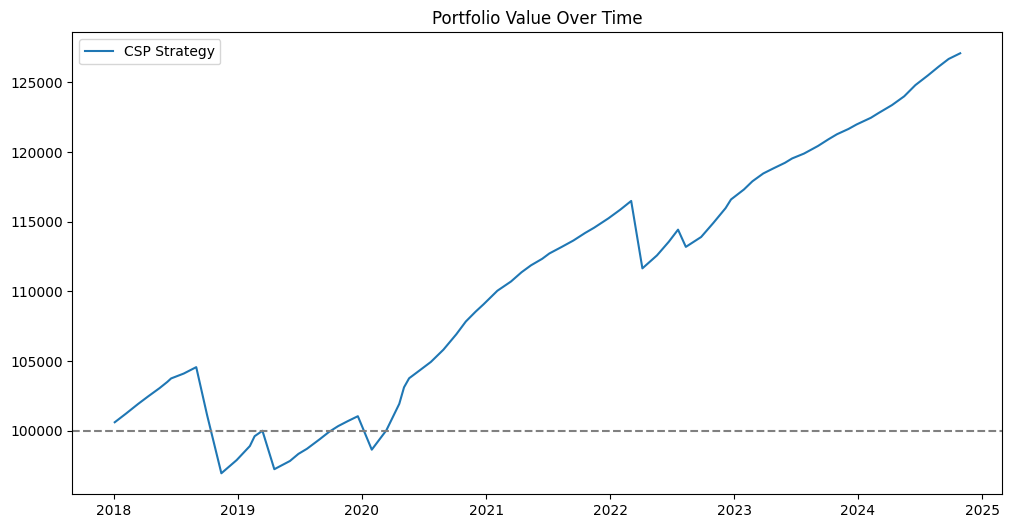

Total Trades: 79
Win Rate: 92.41%
Average Profit per Trade: $342.89


In [162]:
#Portfolio vs. time
plt.figure(figsize = (12,6))
plt.plot(trades_df["entry_date"], trades_df["capital"], label = "CSP Strategy")
plt.axhline(INITIAL_CAPITAL, linestyle = "--", color = "gray")
plt.legend()
plt.title("Portfolio Value Over Time")
plt.show()

#Final "Win Rate" Calculation
total_trades = len(trades_df)
winning_trades = len(trades_df[trades_df['pnl'] > 0])
win_rate = (winning_trades / total_trades) * 100

print(f"Total Trades: {total_trades}")
print(f"Win Rate: {win_rate:.2f}%")
print(f"Average Profit per Trade: ${trades_df['pnl'].mean():,.2f}")

# Buy and Hold Strategy
## Strategy Definition
- Buy AAPL at starting date
- Hold until ending date
- Calculate unrealized gains at the end date
- Same parameters as previous CSP backtest

# Buy and Hold Strategy Logic

In [163]:
initial_share_price = df["Close"].iloc[0]
ending_share_price = df["Close"].iloc[len(df)-1]
buy_hold_return = 100*(ending_share_price-initial_share_price)/initial_share_price
print(f"Total Return: {buy_hold_return}%")

Total Return: 522.45055321591%


# Plot Visuals

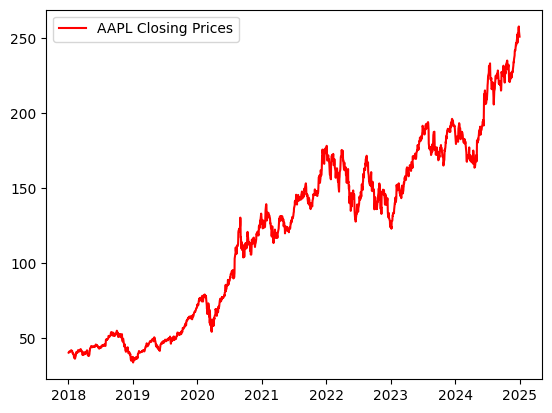

In [164]:
plt.plot(df.index, df["Close"], label = "AAPL Closing Prices", color = "red")
plt.legend()

# Strategy Comparison & Portfolio Overlay

**Hypothesis:**  
SSelling 30 DTE OTM puts while maintaining a 100% long position in AAPL generates "Alpha" (excess return) and outperforms a simple buy-and-hold strategy over a full market cycle

## Strategy Definition
- Underlying: AAPL
- Strategy: Cash-Secured Puts
- Core Position: 100% Long AAPL (Buy & Hold)
- Overlay Strategy: Naked puts (using account value as collateral)
- Entry frequency: Every 30 trading days if no open position
- DTE: 30
- Strike selection: 8% out-of-the-money
- Premium model: Volatility-based approximation
- Exit rules:
  - At expiration OR
  - 50% of max profit (if modeled)
- Assignment handling: Assigned shares valued at expiration close

## Risk & Capital Rules
- Initial capital: $100,000
- Position sizing: 1 contract per trade
- No leverage
- No margin
- Transaction costs: $0 (initially)

## Assumptions & Limitations
- Uses realized volatility as IV proxy
- Assumes fills at theoretical price
- Ignores early assignment